In [1]:
%matplotlib inline
import numpy as np
import pynbody
from pynbody.plot import sph
import matplotlib.pylab as plt
plt.style.use('dark_background')

import ipywidgets
from ipywidgets import interact, interactive, fixed, interact_manual
from snap_io import load_moria_sim_and_kicked, load_moria, load_kicked, load_sim

In [2]:
import contextlib

@contextlib.contextmanager
def np_printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    try:
        yield
    finally: 
        np.set_printoptions(**original)

In [3]:
SIMNUMBER = "69002_p200.0_a600.0_r600.0_c8.15"
kicked=True

In [4]:
resolution = 500
width = 10 # kpc
vmax=2e-1
vmin=5e-4;

In [5]:
snap_list = load_kicked(SIMNUMBER) if kicked else load_moria(SIMNUMBER)

In [6]:
s = snap_list[0]
s

<SimSnap "/home/michele/sim/MySimulations/Moria8Gyr_tidal/sim69002_p200.0_a600.0_r600.0_c8.15/out/snapshot_0001" len=1871020>

In [7]:
def plot_gas_and_stars(sim, velocity_proj=False, **kwargs):
    """Wrapper around pynbody.plot.stars.render using correct smoothing length"""
    sim.properties.pop('boxsize', None)
    sim.g['smooth'] /= 2
    sim.s['smooth'] /= 2
    pynbody.analysis.halo.center(sim)
    if velocity_proj:
        velocity = sim['vel'].mean(axis=0)
        backup = sim['pos'].copy()
        backup_v = sim['vel'].copy()
        v_xy = np.linalg.norm(velocity[0:2])
        v_x, v_y, v_z = velocity
        alpha = np.sign(v_y) * np.arccos(v_x/v_xy) * 180.0/np.pi
        theta = np.arctan(v_z/v_xy) * 180.0/np.pi
        r1=sim.rotate_z(alpha)
        r2=sim.rotate_y(theta)

    fig, (ax_g, ax_s) = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
    try:
        snap = int(sim.filename[-4:])
#         with np_printoptions(precision=2):
#             title = '$t={:5.2f}$ Gyr, snap={}\nv = {}'.format(sim.properties['time'].in_units("Gyr"), snap, velocity)
        im = sph.image(sim.g, qty="rho", units="g cm^-2", subplot=ax_g, #title=title,
                       ret_im=True, show_cbar=False, **kwargs)
        width=kwargs["width"]
        rgbim = pynbody.plot.stars.render(sim, axes=ax_s, width=width, clear=False, plot=False, ret_im=True)
        ax_s.imshow(rgbim[::-1, :], extent=(-width / 2, width / 2, -width / 2, width / 2))
        ax_s.set_xlabel('x [' + str(sim.s['x'].units) + ']')
        ax_s.set_ylabel('y [' + str(sim.s['y'].units) + ']')
        ax_g.set_xlabel('x [' + str(sim.s['x'].units) + ']')
        ax_g.set_ylabel('y [' + str(sim.s['y'].units) + ']')
        
        fig.tight_layout()
        fig.subplots_adjust(top=0.92, bottom=0.15)
        cbar_ax = fig.add_axes([0.2,  0.05, 0.6, 0.02])
        fig.colorbar(im, cax=cbar_ax, orientation='horizontal').set_label("rho [g cm^-2]")
        
        title = '$t={:5.2f}$ Gyr, snap={}'.format(sim.properties['time'].in_units("Gyr"), snap)
        fig.suptitle(title)
    except Exception as e:
        raise(e)
    finally:
        sim.g['smooth'] *= 2
        sim.s['smooth'] *= 2
        if velocity_proj:
            # revert is costly (7% for each transformation w.r.t. the sph.image function)
            # and does not work when the transformation has been applied on a particle family
            # r2.revert()
            # r1.revert()
            sim['pos'] = backup
            sim['vel'] = backup_v
    return

In [8]:
vminmax = ipywidgets.FloatRangeSlider(
    value=[vmin, vmax],
    min=1e-6,
    max=1e-2,
    step=1e-5,
    description='Rho:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='1.0e',
)
snap_slider = ipywidgets.IntSlider(min=0,max=len(snap_list),step=1,value=0, continuous_update=False, description='Snap:')
width_slider = ipywidgets.IntSlider(min=5,max=1000,step=10,value=20, continuous_update=False, description='Width (kpc):')
res_slider = ipywidgets.IntSlider(min=100,max=1000,step=100,value=200, continuous_update=False, description='Resol. (pix):')
proj = ipywidgets.Checkbox(value=False,  description='Velocity projection')

def k(i, velocity_proj, vrange, width, resolution):
    plot_gas_and_stars(snap_list[i], velocity_proj=velocity_proj, width=width, vmin=vrange[0], vmax=vrange[1], resolution=resolution)

In [9]:
interact(k, i=snap_slider, velocity_proj=proj, vrange=vminmax, width=width_slider, resolution=res_slider);

interactive(children=(IntSlider(value=0, continuous_update=False, description='Snap:', max=95), Checkbox(value=False, description='Velocity projection'), FloatRangeSlider(value=(0.0005, 0.01), continuous_update=False, description='Rho:', max=0.01, min=1e-06, readout_format='1.0e', step=1e-05), IntSlider(value=20, continuous_update=False, description='Width (kpc):', max=1000, min=5, step=10), IntSlider(value=200, continuous_update=False, description='Resol. (pix):', max=1000, min=100, step=100), Output()), _dom_classes=('widget-interact',))

In [10]:
# b=ipywidgets.HBox([snap_slider, proj, vminmax, width_slider, res_slider])
# d=dict(zip(k.__code__.co_varnames, b.children))
# f=interactive(k, **d);

In [11]:
s.s

<SimSnap "/home/michele/sim/MySimulations/Moria8Gyr_tidal/sim69002_p200.0_a600.0_r600.0_c8.15/out/snapshot_0001::star" len=14363>

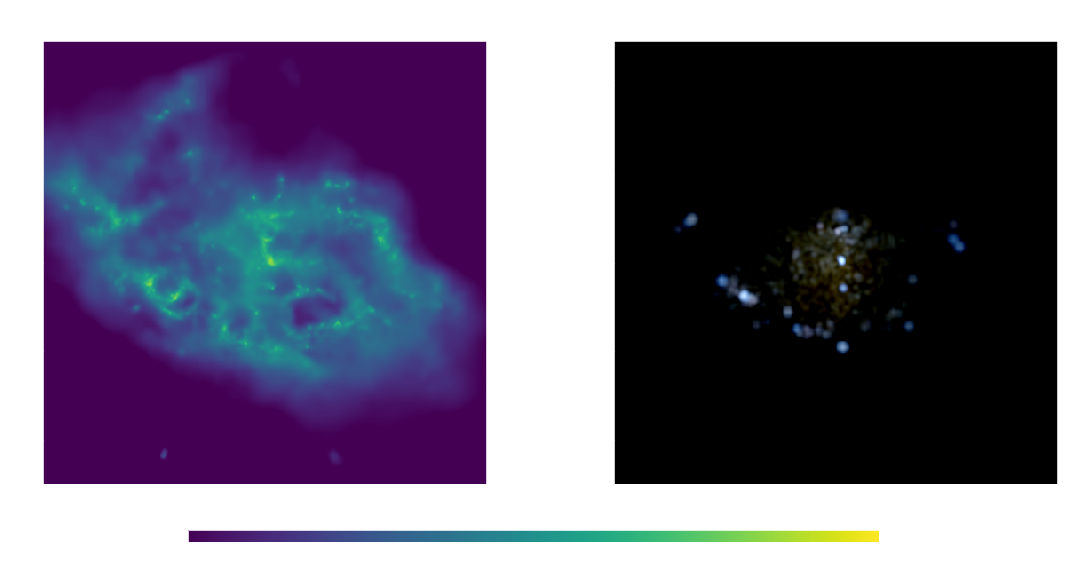

Timer unit: 1e-06 s

Total time: 1.60167 s
File: <ipython-input-7-a4c1ecc45ee1>
Function: plot_gas_and_stars at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def plot_gas_and_stars(sim, velocity_proj=False, **kwargs):
     2                                               """Wrapper around pynbody.plot.stars.render using correct smoothing length"""
     3         1            5      5.0      0.0      sim.properties.pop('boxsize', None)
     4         1          615    615.0      0.0      sim.g['smooth'] /= 2
     5         1          249    249.0      0.0      sim.s['smooth'] /= 2
     6         1       533815 533815.0     33.3      pynbody.analysis.halo.center(sim)
     7         1            3      3.0      0.0      if velocity_proj:
     8         1        27870  27870.0      1.7          velocity = sim['vel'].mean(axis=0)
     9         1         4278   4278.0      0.3          backup = sim['pos'].copy()
    10

In [12]:
%load_ext line_profiler
%lprun -f plot_gas_and_stars plot_gas_and_stars(s, velocity_proj=True, width=width, vmin=vmin, vmax=vmax, resolution=resolution)